# TODO:

Try:

* Different models:
  * Sarsa Linear
  * Sarsa ANN
  * Q-learning Linear?
  * Q-learning ANN without experience replay
  * Q-learning aNN with experience replay (DQN)
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 2)
    
    def forward(self, X):
        return self.linear(X)
model = LinearModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()

In [4]:
X = torch.tensor([
    [1.0, 2, 3, 4],
    [8, 7, 6, 5]
]).to(device)
Y = torch.tensor([
    [4.0, 2],
    [1, 3]
]).to(device)
for _ in range(1000):
    preds = model(X)
    loss = loss_func(Y, preds)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [5]:
preds = model(X)
loss = loss_func(Y, preds)
print(loss)
print(preds)

tensor(1.4211e-14, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([[4.0000, 2.0000],
        [1.0000, 3.0000]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
def select_action_eps_greedy(env, model, state, eps=0.1):
    if np.random.random() < eps:
       return env.action_space.sample().item()
    with torch.no_grad():
        return torch.argmax(model(state)).item()

def update_model(loss_func, target, prediction):
    loss = loss_func(target, prediction)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [7]:
NUM_EPISODES = 1000
env = gym.make("CartPole-v1")
model = LinearModel().to(device)
#optimizer = optim.AdamW(model.parameters(), lr=0.0001, amsgrad=True)
#loss_func = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()
returns = []

for ep in range(NUM_EPISODES):
    observation, info = env.reset()
    state = torch.tensor(observation, device=device)
    action = env.action_space.sample().item()
    truncated = False
    terminated = False
    G = 0

    while not (terminated or truncated):
        observation, reward, terminated, truncated, info = env.step(action)
        next_state = torch.tensor(observation, device=device)
        G += reward
        target = torch.tensor(reward, device=device)
        estimated_value = model(state)[action]

        if not terminated:
            next_action = select_action_eps_greedy(env, model, next_state)
            # next_action = env.action_space.sample().item()
            with torch.no_grad():
                estimated_next_value = model(next_state)[next_action]
            target += estimated_next_value
            state = next_state
            action = next_action

        update_model(loss_func, target, estimated_value)

    returns.append(G)
env.close()

Text(0, 0.5, 'Return')

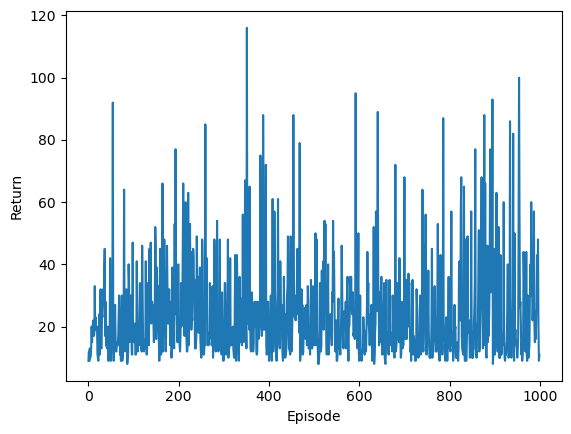

In [8]:
plt.plot(np.arange(len(returns)), returns)
plt.xlabel("Episode")
plt.ylabel("Return")